In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nygrid.run_nygrid as ng_run

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid', '2030StateScenario')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

renewable_data_dir = os.path.join(data_dir, 'renewable')
print('Renewable data directory: {}'.format(renewable_data_dir))

solar_data_dir = os.path.join(data_dir, 'renewable', 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

load_data_dir = os.path.join(data_dir, 'load')
print('Load data directory: {}'.format(load_data_dir))

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid/2030StateScenario
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results
Renewable data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable
Solar data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/solar
Load data directory: /mnt/Bo_HDD/NYgrid-python/data/load


# 1. NYISO 2023-2042 Outlook

In [3]:
outlook_dir = '/mnt/Bo_HDD/NYgrid-python/data/load/nyiso_2023-2042_outlook'

bus_demand_2018 = pd.read_csv(f'{outlook_dir}/bus_demand_2018.csv',
                              index_col=0, parse_dates=True)
bus_load_baseline_2030 = pd.read_csv(f'{outlook_dir}/bus_load_baseline_2030.csv',
                                     index_col=0, parse_dates=True)
bus_load_lower_demand_2030 = pd.read_csv(f'{outlook_dir}/bus_load_lower_demand_2030.csv',
                                         index_col=0, parse_dates=True)
bus_load_higher_demand_2030 = pd.read_csv(f'{outlook_dir}/bus_load_higher_demand_2030.csv',
                                          index_col=0, parse_dates=True)
bus_load_state_scenario_2030 = pd.read_csv(f'{outlook_dir}/bus_load_state_scenario_2030.csv',
                                           index_col=0, parse_dates=True)

# 2. NYGrid Forecast

## A. Update load profile for electrification

In [4]:
res_building_data_dir = os.path.join(data_dir, 'load', 'residential_building')
print('Residential buildings data directory: {}'.format(res_building_data_dir))

com_building_data_dir = os.path.join(data_dir, 'load', 'commercial_building')
print('Commercial buildings data directory: {}'.format(com_building_data_dir))

electric_vehicle_data_dir = os.path.join(data_dir, 'load', 'electric_vehicle')
print('Electric vehicle data directory: {}'.format(electric_vehicle_data_dir))

# Read NYS county attributes and county to bus mapping
county_attrs = pd.read_csv(os.path.join(
    load_data_dir, 'county_attributes.csv'))
county_alloc = pd.read_csv(os.path.join(load_data_dir, 'county_2_bus.csv'))

county_2_bus = dict(zip(county_alloc['NAME'], county_alloc['busIdx']))
county_2_zone = dict(zip(county_alloc['NAME'], county_alloc['ZoneID']))

Residential buildings data directory: /mnt/Bo_HDD/NYgrid-python/data/load/residential_building
Commercial buildings data directory: /mnt/Bo_HDD/NYgrid-python/data/load/commercial_building
Electric vehicle data directory: /mnt/Bo_HDD/NYgrid-python/data/load/electric_vehicle


In [5]:
electrification_dict = {
    'res_building': {
        'data_dir': res_building_data_dir,
        'upgrade_id': 10,
    },
    'com_building': {
        'data_dir': com_building_data_dir,
        'upgrade_id': 18,
    },
    'electric_vehicle': {
        'data_dir': electric_vehicle_data_dir,
        'upgrade_id': 0,
    }
}

In [6]:
electrification_dict = ng_run.read_electrification_data(electrification_dict,
                                                        county_attrs,
                                                        county_alloc)

Get electrification data for 3 sectors:
['res_building', 'com_building', 'electric_vehicle']
Processing res_building electrification data...


Building load data is not available for county G3600030 Single-Family Attached. Skipping...
Building load data is not available for county G3600170 Single-Family Attached. Skipping...
Building load data is not available for county G3600230 Single-Family Attached. Skipping...
Building load data is not available for county G3600490 Single-Family Attached. Skipping...
Building load data is not available for county G3600510 Single-Family Attached. Skipping...
Building load data is not available for county G3600950 Single-Family Attached. Skipping...
Building load data is not available for county G3600970 Multi-Family with 5+ Units. Skipping...
Processing com_building electrification data...
Building load data is not available for county G3600010 Hospital. Skipping...
Building load data is not available for county G3600030 Outpatient. Skipping...
Building load data is not available for county G3600030 SmallHotel. Skipping...
Building load data is not available for county G3600030 LargeHotel

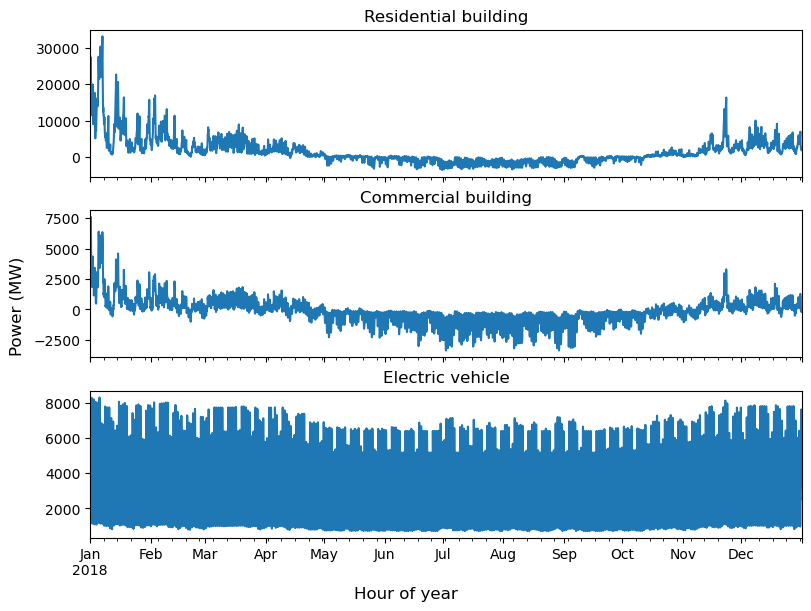

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6),
                        sharex='all', layout='constrained')

electrification_dict['res_building']['load_change'].sum(axis=1).plot(ax=axs[0])
electrification_dict['com_building']['load_change'].sum(axis=1).plot(ax=axs[1])
electrification_dict['electric_vehicle']['load_change'].sum(
    axis=1).plot(ax=axs[2])

titles = ['Residential building', 'Commercial building', 'Electric vehicle']

for i, ax in enumerate(axs):
    ax.set_title(titles[i])

fig.supxlabel('Hour of year')
fig.supylabel('Power (MW)')
plt.show()

In [8]:
for sector, attrs in electrification_dict.items():
    print(f'{sector}:')
    load_change = attrs['load_change']
    annual_energy = load_change.sum().sum()/1000  # Convert to GWh
    # Calculate summer peak 10 hours and winter peak 10 hours
    summer_peak_hours = load_change[load_change.index.month.isin(
        [6, 7, 8])].sum(axis=1).nlargest(5).index
    winter_peak_hours = load_change[load_change.index.month.isin(
        [12, 1, 2])].sum(axis=1).nlargest(5).index

    print(f'Annual energy: {annual_energy:.2f} GWh')
    print('Summer peak hours:')
    print(load_change.loc[summer_peak_hours].sum(axis=1))
    print('Winter peak hours:')
    print(load_change.loc[winter_peak_hours].sum(axis=1))
    print()

res_building:
Annual energy: 13115.69 GWh
Summer peak hours:
timestamp
2018-06-04 06:00:00    413.590036
2018-06-04 07:00:00    367.438897
2018-06-06 06:00:00    322.561850
2018-06-11 06:00:00    307.055780
2018-06-07 06:00:00    288.558908
dtype: float64
Winter peak hours:
timestamp
2018-01-07 07:00:00    33090.668752
2018-01-07 06:00:00    32601.479845
2018-01-07 05:00:00    31902.268435
2018-01-07 08:00:00    30722.338344
2018-01-07 04:00:00    30493.015093
dtype: float64

com_building:
Annual energy: -1925.84 GWh
Summer peak hours:
timestamp
2018-06-04 05:00:00   -101.095472
2018-06-24 05:00:00   -102.763934
2018-06-03 05:00:00   -110.582048
2018-06-24 02:00:00   -123.553861
2018-06-24 03:00:00   -126.650025
dtype: float64
Winter peak hours:
timestamp
2018-01-01 07:00:00    7602.751905
2018-01-01 08:00:00    7412.572319
2018-01-01 06:00:00    7021.471998
2018-01-01 09:00:00    6427.466507
2018-01-05 09:00:00    6386.268641
dtype: float64

electric_vehicle:
Annual energy: 28559.20 G

## B. BTM PV

In [9]:
btmpv_farms = [
    'btmpv_params_baseline_2030',
    # 'btmpv_params_lower_demand_2030',
    # 'btmpv_params_higher_demand_2030',
    # 'btmpv_params_baseline_2040',
    # 'btmpv_params_lower_demand_2040',
    # 'btmpv_params_higher_demand_2040',
]

# Process solar farm parameters
btmpv_farm_list = []
for group in btmpv_farms:
    btmpv_farm = pd.read_excel(os.path.join(data_dir, 'renewable', 'solar_projects.xlsx'),
                               sheet_name=group)
    btmpv_farm = btmpv_farm[['Name', 'p_cap_ac', 'p_county']]

    # Replace 'St Lawrence' with 'St. Lawrence'
    btmpv_farm['p_county'] = btmpv_farm['p_county'].replace(
        {'St Lawrence': 'St. Lawrence'})
    btmpv_farm_list.append(btmpv_farm)

btmpv_params_2030 = pd.concat(btmpv_farm_list, axis=0)
btmpv_params_2030['Zone'] = btmpv_params_2030['p_county'].map(county_2_zone)
btmpv_params_2030['PTID'] = 'NaN'
btmpv_params_2030['Capacity (MW)'] = btmpv_params_2030['p_cap_ac']
btmpv_params_2030['Unit Type'] = 'PV'
btmpv_params_2030['Fuel Type Primary'] = 'SUN'
btmpv_params_2030['2023 Net Energy (GWh)'] = 'NaN'
btmpv_params_2030['Notes'] = 'NYGRID'
btmpv_params_2030['min_gen'] = 0
btmpv_params_2030['gen_bus'] = btmpv_params_2030['p_county'].map(county_2_bus)
btmpv_params_2030['max_ramp_hourly'] = btmpv_params_2030['Capacity (MW)']
btmpv_params_2030 = btmpv_params_2030.drop(columns=['p_cap_ac'])

# Combine with existing upv parameters
btmpv_params_2030 = btmpv_params_2030.reset_index(drop=True)

btmpv_2_bus = dict(
    zip(btmpv_params_2030['Name'], btmpv_params_2030['gen_bus']))

In [10]:
# Utility PV generation profile
btmpv_farm_gen_list = list()
for group in btmpv_farms:
    btmpv_farm_gen = pd.read_csv(os.path.join(solar_data_dir, f'{group}_solar_gen_1hr_MW.csv'),
                                 parse_dates=['Time'], index_col='Time').asfreq('H')
    btmpv_farm_gen_list.append(btmpv_farm_gen)

btmpv_gen_profile_2030 = pd.concat(btmpv_farm_gen_list, axis=1)

# Remove timezone info
btmpv_gen_profile_2030.index = btmpv_gen_profile_2030.index.tz_localize(None)

# Allocate to bus
btmpv_gen_profile_2030 = btmpv_gen_profile_2030.groupby(
    btmpv_2_bus, axis=1).sum()

<Axes: xlabel='Time'>

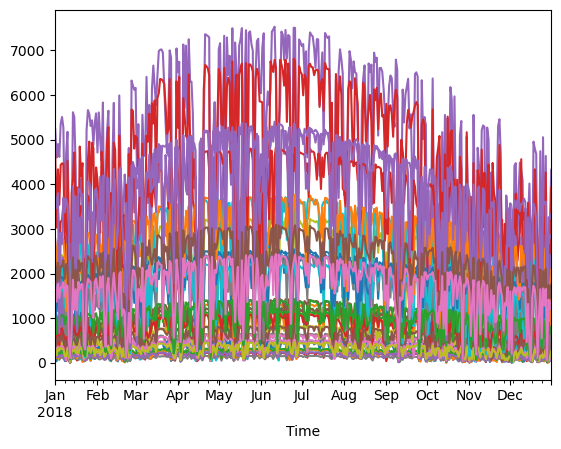

In [11]:
btmpv_gen_profile_2030.resample('D').sum().plot(legend=False)

In [12]:
# Calculate summer peak 10 hours and winter peak 10 hours
summer_peak_hours = btmpv_gen_profile_2030[btmpv_gen_profile_2030.index.month.isin(
    [6, 7, 8])].sum(axis=1).nlargest(5).index
winter_peak_hours = btmpv_gen_profile_2030[btmpv_gen_profile_2030.index.month.isin(
    [12, 1, 2])].sum(axis=1).nlargest(5).index

print('Summer peak hours:')
display(btmpv_gen_profile_2030.loc[summer_peak_hours].sum(axis=1))
print('Winter peak hours:')
display(btmpv_gen_profile_2030.loc[winter_peak_hours].sum(axis=1))

Summer peak hours:


Time
2018-06-11 10:00:00    7408.246154
2018-06-11 11:00:00    7408.246154
2018-06-11 12:00:00    7408.246154
2018-06-17 11:00:00    7408.246154
2018-06-17 12:00:00    7408.246154
dtype: float64

Winter peak hours:


Time
2018-01-26 12:00:00    7408.246154
2018-02-17 11:00:00    7408.246154
2018-02-17 12:00:00    7408.246154
2018-02-27 11:00:00    7408.246154
2018-02-27 12:00:00    7408.246154
dtype: float64

## C. Combine

In [13]:
res_bldg_profile = electrification_dict['res_building']['load_change']
com_bldg_profile = electrification_dict['com_building']['load_change']
ev_profile = electrification_dict['electric_vehicle']['load_change']

In [14]:
raw_ev_annual_energy = ev_profile.sum().sum()/1000
raw_ev_summer_peak = ev_profile[ev_profile.index.month.isin([
    6, 7, 8])].sum(axis=1).max()
raw_ev_winter_peak = ev_profile[ev_profile.index.month.isin([
    12, 1, 2])].sum(axis=1).max()
print(f'Raw EV annual energy: {raw_ev_annual_energy:.2f} GWh')
print(f'Raw EV summer peak: {raw_ev_summer_peak:.2f} MW')
print(f'Raw EV winter peak: {raw_ev_winter_peak:.2f} MW')

Raw EV annual energy: 28559.20 GWh
Raw EV summer peak: 7176.19 MW
Raw EV winter peak: 8290.41 MW


In [15]:
total_bldg_profile = res_bldg_profile + com_bldg_profile
raw_bldg_annual_energy = total_bldg_profile.sum().sum()/1000
raw_bldg_summer_peak = total_bldg_profile[total_bldg_profile.index.month.isin([
    6, 7, 8])].sum(axis=1).max()
raw_bldg_winter_peak = total_bldg_profile[total_bldg_profile.index.month.isin([
    12, 1, 2])].sum(axis=1).max()
print(f'Raw building annual energy: {raw_bldg_annual_energy:.2f} GWh')
print(f'Raw building summer peak: {raw_bldg_summer_peak:.2f} MW')
print(f'Raw building winter peak: {raw_bldg_winter_peak:.2f} MW')

Raw building annual energy: 11189.85 GWh
Raw building summer peak: 159.76 MW
Raw building winter peak: 39053.73 MW


In [16]:
btmpv_annual_energy = btmpv_gen_profile_2030.sum().sum()/1000
btmpv_summer_peak = btmpv_gen_profile_2030[btmpv_gen_profile_2030.index.month.isin(
    [6, 7, 8])].sum(axis=1).max()
btmpv_winter_peak = btmpv_gen_profile_2030[btmpv_gen_profile_2030.index.month.isin(
    [12, 1, 2])].sum(axis=1).max()
print(f'BTMPV annual energy: {btmpv_annual_energy:.2f} GWh')
print(f'BTMPV summer peak: {btmpv_summer_peak:.2f} MW')
print(f'BTMPV winter peak: {btmpv_winter_peak:.2f} MW')

BTMPV annual energy: 17425.24 GWh
BTMPV summer peak: 7408.25 MW
BTMPV winter peak: 7408.25 MW


In [17]:
ev_annual_energy_nyiso_2030 = 7463  # GWh # NYISO 2023 Gold Book Table I-11b
ev_summer_peak_nyiso_2030 = 1112  # MW # NYISO 2023 Gold Book Table I-11c
ev_winter_peak_nyiso_2030 = 1419  # MW # NYISO 2023 Gold Book Table I-11d

# GWh # NYISO 2023 Gold Book Table I-13a
bldg_annual_energy_nyiso_2030 = 9485
bldg_summer_peak_nyiso_2030 = 396  # MW # NYISO 2023 Gold Book Table I-13b
bldg_winter_peak_nyiso_2030 = 5731  # MW # NYISO 2023 Gold Book Table I-13c

btmpv_annual_energy_nyiso_2030 = 11879  # GWh # NYISO 2023 Gold Book Table I-9b
btmpv_summer_peak_nyiso_2030 = 6889  # MW # NYISO 2023 Gold Book Table I-9d

In [18]:
# Scaling by annual energy
# ev_scaling_factor = ev_annual_energy_nyiso_2030 / raw_ev_annual_energy # 0.26
# bldg_scaling_factor = bldg_annual_energy_nyiso_2030 / raw_bldg_annual_energy # 0.85
btmpv_scaling_factor = btmpv_annual_energy_nyiso_2030 / btmpv_annual_energy # 0.68

# Scaling by peak
ev_scaling_factor = ev_winter_peak_nyiso_2030 / raw_ev_winter_peak # 0.17
bldg_scaling_factor = bldg_winter_peak_nyiso_2030 / raw_bldg_winter_peak # 0.15
# btmpv_scaling_factor = btmpv_summer_peak_nyiso_2030 / btmpv_summer_peak # 0.93

print(f'EV scaling factor: {ev_scaling_factor:.2f}')
print(f'Building scaling factor: {bldg_scaling_factor:.2f}')
print(f'BTMPV scaling factor: {btmpv_scaling_factor:.2f}')

EV scaling factor: 0.17
Building scaling factor: 0.15
BTMPV scaling factor: 0.68


In [19]:
load_profile_new = bus_demand_2018.copy()

load_profile_new = load_profile_new.add(
    total_bldg_profile * bldg_scaling_factor, fill_value=0)
load_profile_new = load_profile_new.add(
    ev_profile * ev_scaling_factor, fill_value=0)
load_profile_new = load_profile_new.sub(
    btmpv_gen_profile_2030 * btmpv_scaling_factor, fill_value=0)

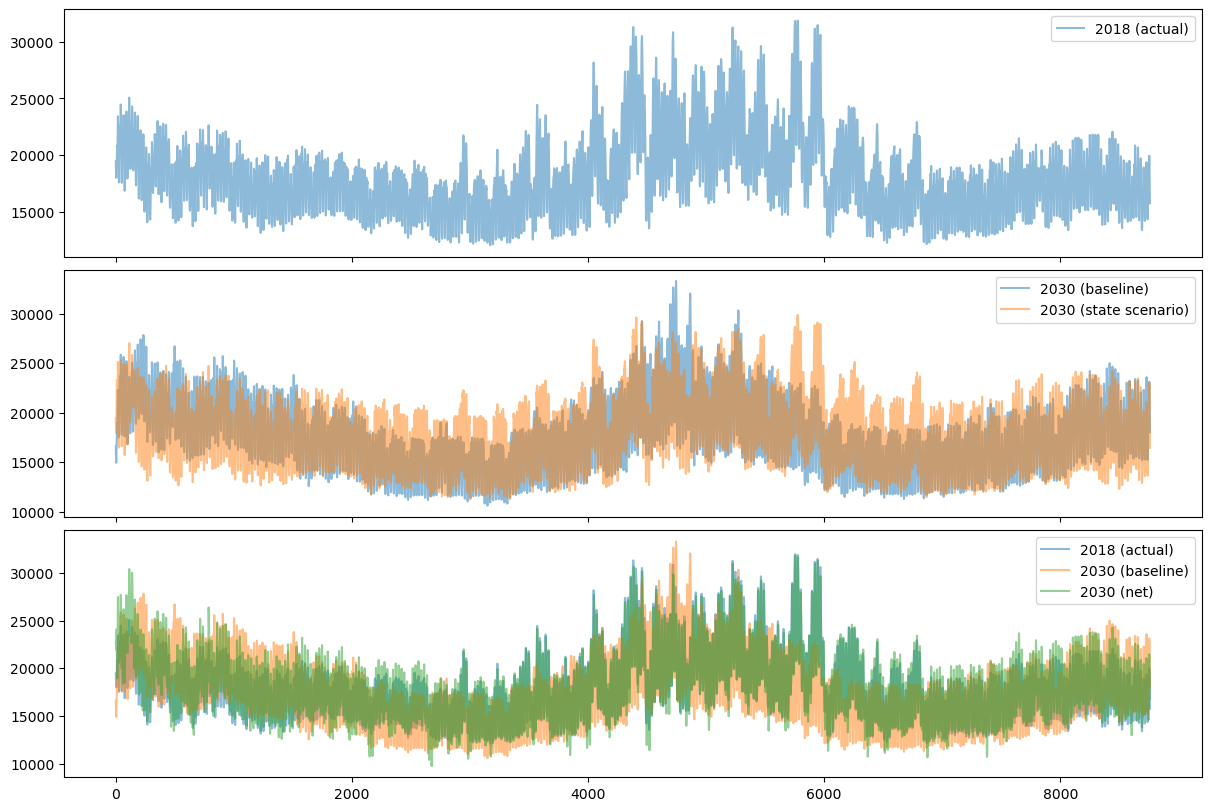

In [20]:
fig, axs = plt.subplots(3, figsize=(12, 8), layout='constrained',
                        sharex=True)
axs[0].plot(range(len(bus_demand_2018)),
            bus_demand_2018.sum(axis=1), label='2018 (actual)', alpha=0.5)

axs[1].plot(range(len(bus_load_baseline_2030)),
            bus_load_baseline_2030.sum(axis=1), label='2030 (baseline)', alpha=0.5)
# axs[1].plot(range(len(bus_load_lower_demand_2030)),
#             bus_load_lower_demand_2030.sum(axis=1), label='2030 (lower demand)', alpha=0.5)
# axs[1].plot(range(len(bus_load_higher_demand_2030)),
#             bus_load_higher_demand_2030.sum(axis=1), label='2030 (higher demand)', alpha=0.5)
axs[1].plot(range(len(bus_load_state_scenario_2030)),
            bus_load_state_scenario_2030.sum(axis=1), label='2030 (state scenario)', alpha=0.5)

axs[2].plot(range(len(bus_demand_2018)),
            bus_demand_2018.sum(axis=1), label='2018 (actual)', alpha=0.5)
axs[2].plot(range(len(bus_load_baseline_2030)),
            bus_load_baseline_2030.sum(axis=1), label='2030 (baseline)', alpha=0.5)
axs[2].plot(range(len(load_profile_new)),
            load_profile_new.sum(axis=1), label='2030 (net)', alpha=0.5)

for ax in axs:
    ax.legend(loc='upper right')
plt.show()

In [21]:
# Compare forecasts peak demand
df_list = [
    bus_demand_2018.sum(axis=1),
    bus_load_baseline_2030.sum(axis=1),
    bus_load_lower_demand_2030.sum(axis=1),
    bus_load_higher_demand_2030.sum(axis=1),
    bus_load_state_scenario_2030.sum(axis=1),
    load_profile_new.sum(axis=1)
]

summer_peaks = list()
winter_peaks = list()

for df in df_list:
    summer_peak_hours = df[df.index.month.isin([6, 7, 8])].nlargest(5)
    winter_peak_hours = df[df.index.month.isin([12, 1, 2])].nlargest(5)

    summer_peaks.append(summer_peak_hours.to_numpy())
    winter_peaks.append(winter_peak_hours.to_numpy())

summer_peaks = pd.DataFrame(summer_peaks, columns=['1', '2', '3', '4', '5'],
                            index=['2018', '2030_baseline', '2030_lower_demand',
                                   '2030_higher_demand', '2030_state_scenario',
                                   '2030_net'])
winter_peaks = pd.DataFrame(winter_peaks, columns=['1', '2', '3', '4', '5'],
                            index=['2018', '2030_baseline', '2030_lower_demand',
                                   '2030_higher_demand', '2030_state_scenario',
                                   '2030_net'])

In [22]:
summer_peaks

,1,2,3,4,5
2018,31860.900000,31858.200000,31824.500000,31766.300000,31734.900000
2030_baseline,33290.000000,33071.000000,32879.400000,32629.200000,32335.600000
2030_lower_demand,30505.300000,30433.500000,30178.100000,30124.800000,29951.400000
2030_higher_demand,33494.500000,33217.300000,33214.600000,32831.400000,32618.800000
2030_state_scenario,29862.000000,29610.000000,29579.000000,29576.000000,29570.000000
2030_net,31944.453144,31607.941388,31310.084556,31171.655573,31114.313346


In [23]:
winter_peaks

,1,2,3,4,5
2018,25080.500000,25012.100000,24615.100000,24470.800000,24418.700000
2030_baseline,27816.000000,27432.800000,27387.700000,27326.300000,27034.800000
2030_lower_demand,29624.000000,29187.000000,29156.300000,29049.100000,28722.200000
2030_higher_demand,31467.100000,30976.300000,30947.500000,30838.500000,30450.200000
2030_state_scenario,26999.000000,26517.000000,26382.000000,25799.000000,25723.000000
2030_net,30388.416279,30165.548683,30144.272949,29996.737282,29941.737927


# 3. Write load profile

In [30]:
bus_prop = pd.read_csv(os.path.join(grid_data_dir, 'bus_prop.csv'))

In [31]:
load_profile_out = pd.DataFrame(columns=bus_prop['BUS_I'].values,
                                index=load_profile_new.index)

# Update bus-wise load profile in NYCA
load_profile_out.update(load_profile_new)

# External load profile are zero
# Import and export flow are set in the generator profiles
load_profile_out = load_profile_out.fillna(0)

# Set negative load to zero
load_profile_out[load_profile_out < 0] = 0

# Round to 2 decimal places
load_profile_out = load_profile_out.round(2)

<Axes: xlabel='TimeStamp'>

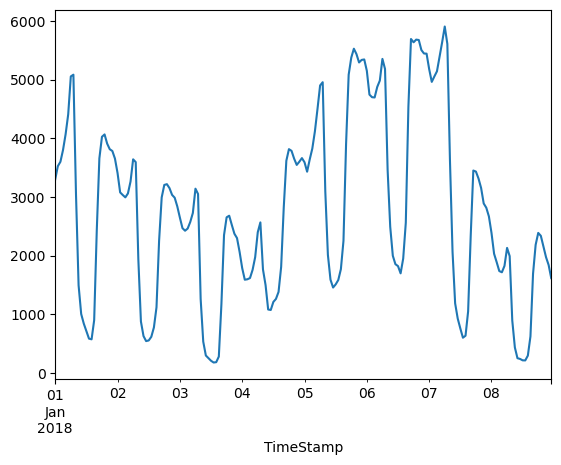

In [32]:
load_profile_out['2018-01-01':'2018-01-08'].sum(axis=1).plot(legend=False)

<Axes: xlabel='TimeStamp'>

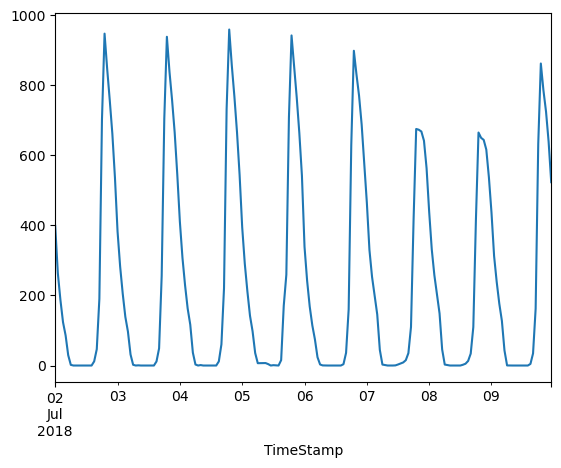

In [33]:
load_profile_out['2018-07-02':'2018-07-09'].sum(axis=1).plot(legend=False)

In [34]:
load_profile_out.to_csv(os.path.join(grid_data_dir, 'load_profile_2030.csv'))